#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
# TAKEAWAY: space derivative depend on nodes granularity. 
# Need increase number of nodes!

In [3]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random

In [4]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [5]:
# from diffeqpy import ode
# from diffeqpy import de

In [6]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [7]:
from sympy import *

In [8]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [9]:
mp = 96 #  (submerged) [kg/m]

In [10]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [11]:
node_N=2

In [12]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [13]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [15]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [16]:
DT=np.diag(diag_DT) # (35) in [2]

In [17]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [18]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
# diag_CT = 1e10*np.array([1, 1, 1]) 

In [19]:
CT=np.diag(diag_CT)

In [20]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [21]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [22]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [23]:
rng = np.random.default_rng()

In [24]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [25]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
#     print(Re_t_(xyz[0]))
    return np.apply_along_axis(Re_t_, 1, xyz)

In [26]:
# φ, θ, ψ= np.zeros(node_N),np.zeros(node_N),np.zeros(node_N)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.95500422,  0.21451911, -0.20481333],
       [-0.04611742,  0.78955935,  0.6119389 ],
       [ 0.29298487, -0.57495877,  0.76392557]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.000700


In [29]:
Ret

array([[[ 0.95500422,  0.21451911, -0.20481333],
        [-0.04611742,  0.78955935,  0.6119389 ],
        [ 0.29298487, -0.57495877,  0.76392557]],

       [[ 0.75043186, -0.54695813,  0.37106444],
        [ 0.19332085,  0.71850044,  0.66811988],
        [-0.63204357, -0.42964395,  0.64492403]]])

In [30]:
Ret.shape

(2, 3, 3)

In [31]:
# Dphi1, Dphi2, Dphi3 = symbols("Dphi1 Dphi2 Dphi3")
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret,B.T)
    return ans.T

In [33]:
dx**2

array([0.21773396, 0.000368  ])

In [34]:
C1(dx,dy,dz,Ret)

array([[ 0.64623671,  0.09248824],
       [-2.68368326, -0.137786  ],
       [-1.78572147,  0.06708592]])

In [35]:
C1(dx,dy,dz,Ret).shape

(3, 2)

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.001194


In [37]:
1/2*d0*qw*np.dot(DT,np.array([0.09,0.12727922, 0.12727922])) 

array([52.6516875 , 74.46073019, 74.46073019])

In [38]:
def fD(dx,dy,dz,DT,Ret):
#     print(dx)
#     print(C1(dx,dy,dz).shape) m2*kg/m3 N/m m2/s2*rad
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret)

array([[  3708.77440781,    530.79316432],
       [-15401.74928607,   -790.75850838],
       [-10248.31611885,    385.00835697]])

In [40]:
fD(dx,dy,dz,DT,Ret).T

array([[  3708.77440781, -15401.74928607, -10248.31611885],
       [   530.79316432,   -790.75850838,    385.00835697]])

In [41]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.001317


In [42]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [43]:
# Mat=np.matrix([[1.3,.4,6.7],[9,7,6],[3.3,5.6,7]])

In [44]:
I=np.identity(3)

In [45]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000263


In [46]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [47]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [48]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [49]:
DR=np.diag(diag_DR) 

In [50]:
dI= 0.69# Inner diameter of pipe, [m]

In [51]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [52]:
Ar

0.08091250419136858

In [53]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [54]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [55]:
from numpy import linalg as LA

In [56]:
def k_sigma(hi,d0,fg_e):
    ans=[]
#     print('hi',hi)
    for it in hi:
#         print(it)
        if it<0:
            ans.append(0)
        elif 0<=it<=d0/20:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
        else:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*hi**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))
#     print(ans)         
     
    return np.array(ans).reshape(node_N,1)   

In [57]:
x,y,z=np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)])

In [58]:
def hi(x,y,z,d0):
    return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [59]:
startTime1 = datetime.now()
hi(x,y,z,d0)
print(datetime.now() - startTime1)

0:00:00.000221


In [60]:
k_sigma(hi(x,y,z,d0),d0,fg_e)

array([[6338.99811768],
       [6338.99811768]])

In [61]:
startTime1 = datetime.now()
k_sigma(hi(x,y,z,d0),d0,fg_e)
print(datetime.now() - startTime1)

0:00:00.000577


In [62]:
# TODO: force shoud be acting only at nodes that are in contact with the seabed
def sigma(x,y,z):
    return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [63]:
startTime1 = datetime.now()
sigma(x,y,z)
print(datetime.now() - startTime1)

0:00:00.000513


In [64]:
# # angles should be in radians, otherwise np.radians them  
# def Re_t_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
  
#     Cφ=np.matrix([[1,0,0],
#                       [0,np.cos(φ),-np.sin(φ)],
#                       [0,np.sin(φ),np.cos(φ)]])

#     Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
#                       [0,1,0],
#                       [-np.sin(θ),0,np.cos(θ)]])

#     Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
#                       [np.sin(ψ),np.cos(ψ),0],
#                       [0,0,1]])
        

#     return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [65]:
# Re_t_([1,2,3])

In [66]:
# φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [67]:
# def Re_t(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
# #     print(Re_t_(xyz[0]))
#     return np.apply_along_axis(Re_t_, 1, xyz)

In [68]:
# φ, θ, ψ

In [69]:
# Re_t_(np.array([φ[0], θ[0], ψ[0]]))

In [70]:
# startTime1 = datetime.now()
# Ret=Re_t(φ,θ,ψ)
# print(datetime.now() - startTime1)

In [71]:
# Ret

In [72]:
# vessel motion
# Fossen book p.101, p.190, p.384, p.431
# Fossen paper, section 6

In [73]:
# Fossen paper, equation (12)

In [74]:
# φ,θ,ψ=1,2,3

In [75]:
def Re_b(Ret):
    return np.dot(Ret, Rb_t ) # (5) in[3]

In [76]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000205


In [77]:
# p=np.dot(Re_b, phi) # (41) in[3]

In [78]:
# def d_s(da,db,dc,dt,ds):
    
def d_s(da,db,dc,x,y,z):
#     return np.vstack([da*dt/ds,db*dt/ds,dc*dt/ds])
#     print(np.diff(da))

    ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
                 +np.diff(z,prepend=z[0])**2)
#     print(ds)
    ds[ds == 0] = 1
    return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [79]:
# a=[1,2,3]
# np.diff(a,prepend=a[0])

In [80]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)


In [81]:
startTime1 = datetime.now()
d_s(x,y,z,x,y,z)
print(datetime.now() - startTime1)

0:00:00.000833


In [82]:
# φ,θ,ψ=np.array([2.3 for i in range(node_N)]),np.array([1.3 for i in range(node_N)]),np.array([2.1 for i in range(node_N)])


In [83]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [84]:
def ne(x,y,z,Ret):
#     print(np.multiply(Re_t(φ,θ,ψ),CT).shape)
#     print(np.multiply(np.multiply(Re_t(φ,θ,ψ),CT),
#                          Re_t(φ,θ,ψ)).shape)
#     print(d_s(dx,dy,dz,dt,ds).shape)
    
    A=np.multiply(np.multiply(Ret,CT),Ret)
#     B=d_s(dx,dy,dz,dt,ds).T
    B=d_s(x,y,z,x,y,z).T
    
#     print(A)
    
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)
#     return np.array(ans)

In [85]:
def ne_(dx,dy,dz,DT,Ret):
#     print('ho',fg_e.shape)
#     print(fD(dx,dy,dz,DT))
#     print(sigma(x,y,z))
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T
#     return -fg_e-fD(dx,dy,dz,DT)

In [86]:
sigma(x,y,z)

array([[     0.        ,      0.        , 226706.96401639],
       [     0.        ,      0.        , 347179.74299784]])

In [87]:
ne_(dx,dy,dz,DT,Ret)

array([[-3708.77440781,  -530.79316432],
       [15401.74928607,   790.75850838],
       [10120.15157662,  -513.1728992 ]])

In [88]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [89]:
startTime1 = datetime.now()
ne(x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000737


In [90]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000607


In [91]:
Re_b(Ret).shape

(2, 3, 3)

In [92]:
def Irho_e(Ret):
    return np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 

In [93]:
Irho_e(Ret)

array([[[ 91.2033052 ,   0.        ,   0.        ],
        [  0.        ,  62.34039608,   0.        ],
        [  0.        ,   0.        , 116.71645575]],

       [[ 56.31479813,   0.        ,   0.        ],
        [  0.        ,  51.62428758,   0.        ],
        [  0.        ,   0.        ,  83.18540059]]])

In [94]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000301


In [95]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ)*np.cos(ψ),-np.sin(ψ),0],
#                   [np.cos(θ)*np.sin(ψ),np.cos(ψ),0],
#                   [-np.sin(θ),0,1]])
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [96]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [97]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000737


In [98]:
def ωe(φ,θ,ψ,x,y,z):  # (100) in [2]
    A=Π(φ,θ,ψ)
#     print(A)
#     B=np.array([φ,θ,ψ]).T
    B=d_s(φ,θ,ψ,x,y,z).T
#     print(B)
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)    
#     return np.array(ans) 
#     ans=[]
#     for i in range(len(φ)):
#         ans.append(np.dot(Π(φ[i],θ[i],ψ[i]),np.array([φ[i],θ[i],ψ[i]])))  # (100) in [2]
#     return np.vstack(ans)    

In [99]:
# np.dot(np.matrix([[-0.13504574, -0.86320937,  0.        ],
#   [ 0.23090749, -0.5048461 ,  0.        ],
#   [-0.96355819,  0.,          1.        ]]),np.array([2.3, 1.3, 2.1]))

In [100]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,x,y,z)
print(datetime.now() - startTime1)

0:00:00.000987


In [101]:
diag_CR = 1e11*np.array([1, 1, 1]) 
# diag_CR = 1e7*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [102]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [103]:
def me(φ,θ,ψ,x,y,z,Ret):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=ωe(φ,θ,ψ,x,y,z)
    ans=[]
    return np.einsum('ijk,ik->ij', A,B) 
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
#     return np.array(ans)
#     tmp=[]
#     for i in range(len(φ)):
#         tmp.append(np.dot(np.dot(Re_t(φ[i],θ[i],ψ[i]),CR),Re_t(φ[i],θ[i],ψ[i]).T))
        
#     tmp1= ωe(φ,θ,ψ)
    
#     ans=[]
#     for i in range(len(tmp1)):
#         ans.append(np.dot(np.array(tmp[i]),tmp1[i] ))
#     return np.array(ans).reshape(3,-1)

In [104]:
startTime1 = datetime.now()
me_=me(φ,θ,ψ,x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000981


In [105]:
me_

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.12720035e+07, 4.50377563e+08, 1.80459819e+08]])

In [106]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [107]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [108]:
ne_(dx,dy,dz,DT,Ret)

array([[-3708.77440781,  -530.79316432],
       [15401.74928607,   790.75850838],
       [10120.15157662,  -513.1728992 ]])

In [109]:
C=ne(x,y,z,Ret)
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [110]:
d_s(a,b,c,x,y,z)

array([[       0.        ,  2459108.744367  ],
       [       0.        , -2669112.61499407],
       [       0.        ,  1114636.82161115]])

In [111]:
Re_b(Ret).shape

(2, 3, 3)

In [112]:
ne_(dx,dy,dz,DT, Ret).T

array([[-3708.77440781, 15401.74928607, 10120.15157662],
       [ -530.79316432,   790.75850838,  -513.1728992 ]])

In [113]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([ 82.27698788, -15.3089531 ]),
 array([ 94.82311188, 145.40449453]),
 array([-0.46661971, -0.01918324]),
 numpy.ndarray,
 array([-1.73298223, -0.0342091 ]))

In [114]:
ne_(dx,dy,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dy,dz,DT,Ret).T)

array([[-6019.44191144, 33926.29794776,  7909.20852412],
       [-1552.04927992,   913.44444146,  -848.39064114]])

In [115]:
ne_(dx,dy,dz,DT,Ret).T

array([[-3708.77440781, 15401.74928607, 10120.15157662],
       [ -530.79316432,   790.75850838,  -513.1728992 ]])

### Vessel

In [116]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

#         self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.G =1.0e10 *np.array([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA
        self.G0=self.G
#         print(self.G,self.M)




    def eq_left(self,η, dη):
        φ,θ,ψ=η[3:]
        Ret=Re_t_([φ,θ,ψ])
        A=Re_b(Ret)
        B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
        Z=np.zeros((3,3))
        C0=np.concatenate([A,Z],axis=1)
        C1=np.concatenate([Z,B],axis=1)
        C=np.concatenate([C0,C1],axis=0)

        return (np.matmul(self.D, dη) + np.dot(C,self.G))
        
    def tau(self,η, dη, ddη):
        φ,θ,ψ=η[3:]
        Ret=Re_t_([φ,θ,ψ])
        A=Re_b(Ret)
#         print(Π_([φ,θ,ψ]))
#         print(Re_b(Ret))
        B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
        Z=np.zeros((3,3))
        C0=np.concatenate([A,Z],axis=1)
        C1=np.concatenate([Z,B],axis=1)
        C=np.concatenate([C0,C1],axis=0)
#         print( np.dot(C,self.G).shape)
#         print(self.G)
#         print(np.dot(C,self.G))
#         print(np.matmul(self.M,ddη))
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(C,self.G))
#         return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + self.G)/10000000

In [117]:
V=VesselSemisub()

In [118]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [119]:
tau_force = V.tau(η,dη, ddη)

In [120]:
tau_force

array([ 3.38785484e+06, -2.37412183e+06,  4.34580086e+06, -1.36399445e+10,
        3.02038732e+10,  1.28049082e+10])

In [121]:
class VesselOtter: 
    
    def __init__(
        self, 
        controlSystem="stepInput", 
        r = 0, 
        V_current = 0, 
        beta_current = 0,
        tau_X = 120
    ):
        
        # Constants
        D2R = math.pi / 180     # deg2rad
        self.g = 9.81           # acceleration of gravity (m/s^2)
        rho = 1026              # density of water (kg/m^3)

        if controlSystem == "headingAutopilot":
            self.controlDescription = (
                "Heading autopilot, psi_d = "
                + str(r)
                + " deg"
                )
        else:
            self.controlDescription = "Step inputs for n1 and n2"
            controlSystem = "stepInput"

        self.ref = r
        self.V_c = V_current
        self.beta_c = beta_current * D2R
        self.controlMode = controlSystem
        self.tauX = tau_X  # surge force (N)

        # Initialize the Otter USV model
        self.T_n = 1.0  # propeller time constants (s)
        self.L = 2.0    # Length (m)
        self.B = 1.08   # beam (m)
        self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
        self.u_actual = np.array([0, 0], float)  # propeller revolution states
        self.name = "Otter USV (see 'otter.py' for more details)"

        self.controls = [
            "Left propeller shaft speed (rad/s)",
            "Right propeller shaft speed (rad/s)"
        ]
        self.dimU = len(self.controls)

        # Vehicle parameters
        m = 55.0                                 # mass (kg)
        self.mp = 25.0                           # Payload (kg)
        self.m_total = m + self.mp
        self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
        rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
        rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
        self.S_rg = Smtrx(rg)
        self.H_rg = Hmtrx(rg)
        self.S_rp = Smtrx(self.rp)

        R44 = 0.4 * self.B  # radii of gyration (m)
        R55 = 0.25 * self.L
        R66 = 0.25 * self.L
        T_yaw = 1.0         # time constant in yaw (s)
        Umax = 6 * 0.5144   # max forward speed (m/s)

        # Data for one pontoon
        self.B_pont = 0.25  # beam of one pontoon (m)
        y_pont = 0.395      # distance from centerline to waterline centroid (m)
        Cw_pont = 0.75      # waterline area coefficient (-)
        Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

        # Inertia dyadic, volume displacement and draft
        nabla = (m + self.mp) / rho  # volume
        self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
        Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
        self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

        # Experimental propeller data including lever arms
        self.l1 = -y_pont  # lever arm, left propeller (m)
        self.l2 = y_pont  # lever arm, right propeller (m)
        self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
        self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
        self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
        self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

        # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
        #               O3       Ig ]
        MRB_CG = np.zeros((6, 6))
        MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
        MRB_CG[3:6, 3:6] = self.Ig
        MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

        # Hydrodynamic added mass (best practice)
        Xudot = -0.1 * m
        Yvdot = -1.5 * m
        Zwdot = -1.0 * m
        Kpdot = -0.2 * self.Ig[0, 0]
        Mqdot = -0.8 * self.Ig[1, 1]
        Nrdot = -1.7 * self.Ig[2, 2]

        self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

        # System mass matrix
        self.M = MRB + self.MA
        self.Minv = np.linalg.inv(self.M)

        # Hydrostatic quantities (Fossen 2021, Chapter 4)
        Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
        I_T = (
            2
            * (1 / 12)
            * self.L
            * self.B_pont ** 3
            * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
            + 2 * Aw_pont * y_pont ** 2
        )
        I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
        KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
        BM_T = I_T / nabla  # BM values
        BM_L = I_L / nabla
        KM_T = KB + BM_T    # KM values
        KM_L = KB + BM_L
        KG = self.T - rg[2]
        GM_T = KM_T - KG    # GM values
        GM_L = KM_L - KG

        G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
        G44 = rho * self.g * nabla * GM_T
        G55 = rho * self.g * nabla * GM_L
        G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
        LCF = -0.2
        H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
        self.G = H.T @ G_CF @ H
#         print(G_CF.shape)
#         print(H.T)

        # Natural frequencies
        w3 = math.sqrt(G33 / self.M[2, 2])
        w4 = math.sqrt(G44 / self.M[3, 3])
        w5 = math.sqrt(G55 / self.M[4, 4])

        # Linear damping terms (hydrodynamic derivatives)
        Xu = -24.4 *self. g / Umax  # specified using the maximum speed
        Yv = 0
        Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
        Kp = -2 * 0.2 * w4 * self.M[3, 3]
        Mq = -2 * 0.4 * w5 * self.M[4, 4]
        Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

        self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

        # Propeller configuration/input matrix
        B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
        self.Binv = np.linalg.inv(B)

        # Heading autopilot
        self.e_int = 0  # integral state
        self.wn = 1.2  # PID pole placement
        self.zeta = 0.8

        # Reference model
        self.r_max = 10 * math.pi / 180  # maximum yaw rate
        self.psi_d = 0  # angle, angular rate and angular acc. states
        self.r_d = 0
        self.a_d = 0
        self.wn_d = self.wn / 5  # desired natural frequency in yaw
        self.zeta_d = 1  # desired relative damping ratio
    
    
    def eq_left(self,η, dη):
#         φ,θ,ψ=η[3:]
#         Ret=Re_t_([φ,θ,ψ])
#         A=Re_b(Ret)
#         B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
#         Z=np.zeros((3,3))
#         C0_=np.concatenate([A,Z],axis=1)
#         C1_=np.concatenate([Z,B],axis=1)
#         C_=np.concatenate([C0_,C1_],axis=0)
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA

        return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
#         φ,θ,ψ=η[3:]
#         Ret=Re_t_([φ,θ,ψ])
#         A=Re_b(Ret)

#         B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
#         Z=np.zeros((3,3))
        
#         C0_=np.concatenate([A,Z],axis=1)
#         C1_=np.concatenate([Z,B],axis=1)
#         C_=np.concatenate([C0_,C1_],axis=0)
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA
#         print(self.D.shape)
#         print(self.M.shape)
#         print(C.shape)
#         print(self.G.shape)
#         print(np.matmul(self.M,ddη).shape)
#         print(np.matmul(self.D, dη).shape)
#         print(np.matmul(C, dη).shape)
#         print(np.dot(C_,self.G.reshape(6,1)).shape)
#         print(self.G)
#         print(self.G.shape)
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [122]:
V=VesselOtter()

In [123]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [124]:
tau_force = V.tau(η,dη, ddη)

In [125]:
tau_force

array([   0.        ,    0.        , 3925.3734    ,  484.24424147,
       2251.69893789,    0.        ])

In [126]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [127]:
V=VesselSemisub()

In [128]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
# kp, kd=1.95e9,1.5e9
kp,kd=1.95e4, 1.5e4
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [129]:
# x,y,z,φ,θ,ψ=η
# dx,dy,dz,dφ,dθ,dψ=dη

In [130]:
def Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [131]:
# Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0)

In [132]:
# def tau_t(x, dx, φ, θ, ψ, kp, kd,  x_ref = 0, dx_ref=0):
#     F=
#     Ret=Re_t_([φ,θ,ψ])  
#     return np.dot(Re_b(Ret), F)
    


In [133]:
# tau_t(x, dx, φ, θ, ψ, kp, kd)

In [134]:
Hs = 2.5 # significant wave height in m

In [135]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [136]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [137]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [138]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
#     print(-Fx(x,dx, kp, kd, x_ref, dx_ref))
    F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])+wave_coef*np.array([0,0,wave_force(Hs,d0,qw)])).T*np.sin(2*np.pi/Tp*time+1)
#     print(F)
    Ret=Re_t_([φ,θ,ψ])
    
    return  np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)

In [139]:
tau(η, dη, wave_coef, kp, kd,3)

array([ 4425.11907454, -2499.7415493 ,  5240.84730708,     0.        ,
           0.        ,     0.        ])

### Catenary

In [140]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [141]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [142]:
Fx_0=82945396

In [143]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [144]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [145]:
delta_x=horizontal_length/(node_N-1)

In [146]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [147]:
x0,z0

([0.0, 11052.68484446162], [0.0, 694.4218951076863])

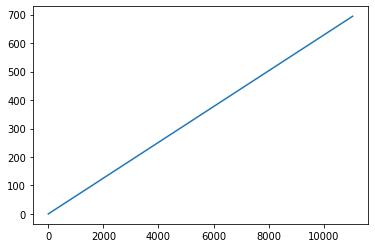

In [148]:
plt.plot(x0, z0)
plt.show()

In [149]:
rng = np.random.default_rng()
q0=np.zeros(12*node_N)

In [150]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [151]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
#     V.G=np.array([-Fx_0,0,0,0,0,0])

#     tau_force = V.eq_left(η, np.zeros(6))
    tau_force=np.array([-Fx_0,0,0,0,0,0])
#     print(tau_force)

    
    
    C=ne(x,y,z,Ret)
    a,b,c=C[:,0],C[:,1],C[:,2]


    Z0=tau_force[:3]

    Z1 = d_s(a,b,c,x,y,z).T
    
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T

    Z= ( 
        Z1 
        + Z2 
        + Z0 
       )

############################################################    
    ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    

    
    me_=me(φ,θ,ψ,x,y,z,Ret)

   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T

    B_ =C3
    B=(np.einsum('ijk,ik->ij', Re_b(Ret), B_)
       -C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

#############
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans
    

In [152]:
from scipy.optimize import fsolve

In [153]:
q0

array([    0.        , 11052.68484446,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,   694.42189511,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [154]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [155]:
root

array([    0.        , 11052.68484446,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,   694.42189511,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [156]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [157]:
x0

[0.0, 11052.68484446162]

In [158]:
x0_

array([    0.        , 11052.68484446])

In [159]:
z0

[0.0, 694.4218951076863]

In [160]:
z0_

array([  0.        , 694.42189511])

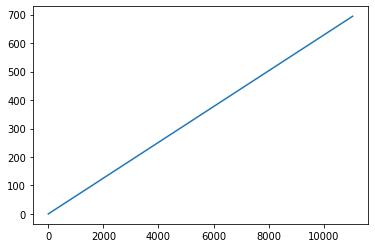

In [161]:
plt.plot(x0_, z0_)
plt.show()

In [162]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_

In [163]:
q0

array([    0.        , 11052.68484446,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,   694.42189511,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

### Modelling

In [164]:
# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx

In [165]:
# simData[1]

In [166]:
# simD_1=np.insert(simData_1, 0, simData_1[0], axis=0)
# simD_2=np.insert(simData_2, 0, simData_2[0], axis=0)

In [167]:
# diff_1=np.diff(simD_1,axis=0)
# diff_2=np.diff(simD_2,axis=0)

In [168]:
# diff=np.concatenate([diff_1,diff_2], axis=0)

In [169]:
# diff=diff_1

In [170]:
# thres =0.1

In [171]:
# def retrieve_name(var):
#     callers_local_vars = inspect.currentframe().f_back.f_locals.items()
#     return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [172]:
# simD=np.concatenate([simD_1,simD_2], axis=0)

In [173]:
# simD = simD_1

In [174]:
# SD0=simD[:, 0]
# SD1=simD[:, 1]
# SD2=simD[:, 2]
# SD3=simD[:, 3]
# SD4=simD[:, 4]
# SD5=simD[:, 5]
# SD6=simD[:, 6]
# SD7=simD[:, 7]
# SD8=simD[:, 8]
# SD9=simD[:, 9]
# SD10=simD[:, 10]
# SD11=simD[:, 11]
# Diff6=diff[:, 6]
# Diff7=diff[:, 7]
# Diff8=diff[:, 8]
# Diff9=diff[:, 9]
# Diff10=diff[:, 10]
# Diff11=diff[:, 11]

In [175]:
# def feedback(Q):
#     x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

#     K = 2 # feedback gain
#     u_x = -K * x 
#     u_y = -K * y
#     u_z = -K * z 
#     u_dx = -K * dx 
#     u_dy = -K * dy 
#     u_dz = -K * dz 
#     u_φ = -K * φ 
#     u_θ = -K * θ
#     u_ψ = -K * ψ 
#     u_dφ= -K * dφ 
#     u_dθ = -K * dθ 
#     u_dψ = -K * dψ 
#     return np.concatenate([u_x, u_dx, u_y, u_dy, u_z, u_dz, u_φ, u_dφ, u_θ, u_dθ, u_ψ, u_dψ], axis=0) 

In [176]:
# def Jv(x, y, z):
    
#     def Jv0(k,x0,x1,y0,y1,z0,z1):
#         tmp1=(x0+x1)/2 
#         tmp2=(y0+y1)/2
#         tmp3=(z0+z1)/2 
#         return np.array([tmp1, tmp2, tmp3]).T 
# #         else:
# #             return np.array([0, 0, 0]).T 
    
#     ans=np.array([Jv0(k, x[k-1],x[k], y[k-1], y[k], z[k-1], z[k]) for k in range(1,node_N)])
    
#     return np.concatenate([ans,np.array([0, 0, 0]).reshape(3,1).T], axis=0).T

In [177]:
# x, y, z = q0[0:node_N],q0[2*node_N:3*node_N],q0[4*node_N:5*node_N]

In [178]:
# q0

In [179]:
# Jv(x, y, z )

In [180]:
# class Time:
#     def __init__(self):
#         self.time=1
# # #         self.n=1
# # # #         self.my_max = sampleTime*N*2
# #         self.my_time=0
# # # #         self.my_n=0
# #         self.my_update=up

In [181]:
# co=Time()

In [182]:
# def asymptote(t):
#     return t/np.sqrt(t**2+1)

In [183]:
from scipy.integrate import solve_ivp

In [184]:
# V.G

In [185]:
# V.G=V.G0

In [186]:
# V.G

In [187]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
#     Q,t=np.array(Q),np.array(t)
    print(t)
#     dt=0
#     dt=abs(t-co.time)
#     print('dt',t,co.time,dt)
#     co.time+=sampleTime
  
#     if co.my_time%co.my_max==0:
#         co.my_n+=1
        
#     co.my_time+=co.my_update     
    
#     print(Q)   
#     print(abs(co.my_time))
    
#     idx = find_nearest(ans_t,  co.my_time%len(ans_t)) #!!!!!!!!!!!!!!!!!!!!!
#     print(idx)
#     idx = find_nearest(ans_t,  t%len(ans_t)) 
#     print('idx',idx)
#     print(t)
#     print(idx)
#     ind=ans_t.index(val)
    # State vectors
#     x_ve = SD0[idx]
#     y_ve = SD1[idx]
#     z_ve = SD2[idx]
#     print(x_ve,y_ve,z_ve)
#     phi_ve = R2D(ssa(SD3[idx]))
#     theta_ve = R2D(ssa(SD4[idx]))
#     psi_v = R2D(ssa(SD5[idx]))
#     phi_ve = ssa(SD3[idx])
#     theta_ve = ssa(SD4[idx])
#     psi_v = ssa(SD5[idx])
#     phi_ve = SD3[idx]
#     theta_ve = SD4[idx]
#     psi_v = SD5[idx]
#     u_ve = SD6[idx]
#     v_ve = SD7[idx]
#     w_ve = SD8[idx]
#     p_ve = SD9[idx]
#     q_ve = SD10[idx]
#     r_ve = SD11[idx]
#     p_ve = ssa(SD9[idx])
#     q_ve = ssa(SD10[idx])
#     r_ve = ssa(SD11[idx])
    
    
#     print(t-co.time)
#     du_ve = Diff6[idx]/sampleTime
#     dv_ve = Diff7[idx]/sampleTime
#     dw_ve = Diff8[idx]/sampleTime
#     dp_ve = Diff9[idx]/sampleTime
#     dq_ve = Diff10[idx]/sampleTime
#     dr_ve = Diff11[idx]/sampleTime
#     print(u_ve, dr_ve )
    
#     co.time=t
#     co.n+=1
#     print(co.time)
#     η=np.array([ x_ve, y_ve, z_ve,phi_ve, theta_ve,  psi_v])
#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
#     ddη=np.array([du_ve, dv_ve, dw_ve, dp_ve, dq_ve, dr_ve])
#     print( dη)
#     print(ddη)
    
#     tau_force = V.tau(η,dη, ddη)*asymptote(t)
#     tau_force = V.tau(η,dη, ddη)
#     co.time += 1
#     print(tau_force )
#     print()
    
    
    
    
#     p_ve = R2D(simData[:, 9][idx])
#     q_ve = R2D(simData[:, 10][idx])
#     r_ve = R2D(simData[:, 11][idx])

#     if t>dt*co.count:
#         co.count+=1
        
#     print(type(Q))
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     print(x0[-1],y0[-1])

#     x[-1]=x_ve+x0[-1]
#     y[-1]=y_ve
#     z[-1]=z_ve+z0[-1]

#     print( x[-1], y[-1], z[-1])
    x[0]=0
    y[0]=0
    z[0]=0
#     print(z)
#     print(z_ve)
#     print(x_ve,y_ve,z_ve)
#     print(x[0],y[0],z[0])
#     print(x[-1],y[-1],z[-1])
#     print()
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
    dx[0]=0
    dy[0]=0
    dz[0]=0
    
    
#     dx[-1]=u_ve
#     dy[-1]=v_ve 
#     dz[-1]=w_ve
#     print(dx,dy.shape, dx.shape)
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
  
    
    
    
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)
    
#     φ[-1]=phi_ve
#     θ[-1]=theta_ve
#     ψ[-1]=psi_v
    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
#     print(left.shape)
#     print(tau(η, dη, wave_force, 0, 0, t))


    # PD controller after 30 sec
#     if t<30:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_force, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:
#     print(η,dη)
#     print('M',V.M)
#     print('C000000',-left + tau(η,dη, wave_coef, kp, kd, t))
    hack =1
    ddη=np.linalg.lstsq(V.M*hack, -left 
                        + tau(η,dη, wave_coef, kp, kd, t)
                        , rcond=None)[0]
#     print('ddη', ddη)
 
    tau_force = V.tau(η,dη,ddη)
#     print(tau_force)
#     print(η,dη,ddη)
#     print(tau_force)
    
#     dφ[-1]=p_ve
#     dθ[-1]= q_ve
#     dψ[-1]=r_ve
#     print(z)    
#     print(t)
    
#     ddx = np.empty_like(y)
#     ddy = np.empty_like(y)
#     ddz = np.empty_like(y)
#     ddφ = np.empty_like(y)
#     ddθ = np.empty_like(y)
#     ddψ= np.empty_like(y)
    C=ne(x,y,z,Ret)
#     print('C',C)
  
    a,b,c=C[:,0],C[:,1],C[:,2]
#     print('abc',a,b,c)
#     print(a,C)
#     print(a)
    
#     for it in [φ,θ,ψ,x,y,z,dx,dy,dz]:
#         print(it)
    # here single Re_b(φ,θ,ψ) etc.
#     print(np.einsum('ijk,ik->ij', Re_b(φ,θ,ψ).astype(float), ne_(x,y,z,dx,dy,dz).astype(float).T))
#     print(ne_(x,y,z,dx,dy,dz).astype(float))
#     Z0=np.zeros((node_N,3))
#     print(tau_force[:3].shape)
#     Z0[-1]=tau_force[:3]
#     print(Z0)
#     Z0=np.dot(Jv(x, y, z ).T,tau_force[:3]).reshape(node_N,1)
#     print(Z0)
#     print()
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z0=tau_force[:3]
#     print(Z0)
#     Z0=tau_force[:3].T
#     print(Z0)
    Z1 = d_s(a,b,c,x,y,z).T
#     print(Z1.shape)
#     Z2 =np.einsum('ijk,ik->ij', Re_b(Ret), ne_(x,y,z,dx,dy,dz,Ret).T)
#     print(Z1,Z2)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)
#     Z=(np.einsum('ijk,ik->ij', Re_b(Ret), Z1 + Z2) 
    Z= ( Z1 + Z2 
        + Z0 
       )

     
############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    for i in range(len(RRRR)):
        a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
    
#     print(ddx,ddy, ddz)
#     print(ddx,ddy, ddz)
#     print('ddx',ddx)  
#     print('ddy',ddy) 
#     print('ddz',ddz) 
    
    me_=me(φ,θ,ψ,x,y,z,Ret)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)

    
#     C1=np.einsum('ijk,ik->ij', Re_b(Ret).astype(np.float32), np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
#                                                         np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
#                                                                   np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    
#     print(Re_b(φ,θ,ψ).shape)
# #     print(me_)
# #     print(me_[:,0])
#     print(d_s(me_[:,0],me_[:,1],me_[:,2],dt,ds).shape)
# #     print(Irho_e(φ,θ,ψ).shape)
#     print(d_s(me_[:,0],me_[:,1],me_[:, 2],dt,ds))
#     print(me_)
#     print('d_s',d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z))
#     C3= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T)
    C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
#     C3=np.einsum('ijk,ik->ij', Re_b(Ret),C3_)
#     print(C3.shape)
#     print(d_s(x,y,z,dt,ds).shape)
#     print(ne(x,y,z,φ,θ,ψ,dt,ds).T.shape)
    C4= np.cross(d_s(x,y,z,x,y,z).T,ne(x,y,z,Ret))
#     print(np.dot(DR,K).shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(np.dot(DR,K[:,0]))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T
#     print('K1',np.array([dφ,dθ,dψ]))
#     C5= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),-np.dot(DR,K1).astype(np.float32).T)
    C5= -np.dot(DR,K1).astype(np.float32).T
#     if np.isnan(np.sum(C1)):
#         print('C1',np.isnan(np.sum(C1)))
#     if np.isnan(np.sum(C2)):    
#         print('C2',np.isnan(np.sum(C2)))
#     if np.isnan(np.sum(C3)):    
#         print('C3',np.isnan(np.sum(C3)))
#     if np.isnan(np.sum(C4)):    
#         print('C4',np.isnan(np.sum(C4)))
#     if np.isnan(np.sum(C5)):    
#         print('C5',np.isnan(np.sum(C5)))
#     print(C5.shape)    
#     C0=np.zeros((node_N,3))
#     C0[-1]=tau_force[3:]
#     print(Π(φ,θ,ψ).shape)
#     print(Re_b(Ret).shape)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),Re_b(Ret)).shape)
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(tau_force[3:])
#     print(C0.shape)
#     .reshape(node_N,3)
#     print(np.einsum('ijk,ikr->ijr',Π(φ,θ,ψ),Re_b(Ret)).shape)
#     if np.isnan(np.sum(C0)):
#         print('C0',np.isnan(np.sum(C0)))
#     for a in [C1,C2,C3,C4,C5,C0]:   
#         if max(abs(np.amax(a)), abs(np.amin(a)))>thres :
#             print('{}'.format( retrieve_name(a)),a)
    
    B_ =(-C1-C2+C3+C4+C5)
    B=(np.einsum('ijk,ik->ij', Re_b(Ret), B_)
       -C0.squeeze()
      )
#     print(B.shape,C0.squeeze().shape)
#     print(B.shape)
#     print(C0, C0.squeeze())
#     print(B)
#     print(B.shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Π(φ,θ,ψ).shape)
#     A1 =Re_b(Ret).astype(np.float32)
    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
#     print(np.einsum('ijk,ijk->ijk',A1,A2))
#     print('A1',A1)
#     print(A1)
#     print('bu',A1[0])
#     print('hey', np.dot(A1[0],A2[0]))
#     print('op', np.einsum('ijk,ikr->ijr',A1,A2))
#     print(Π(φ,θ,ψ).shape)
#     A=np.einsum('ijk,ikr->ijr',np.einsum('ijk,ikr->ijr',A1,A2),A3)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     print(B,A)    
#     if np.isnan(np.sum(A)):     
#         print('A',np.isnan(np.sum(A)))
      
#     if max(abs(np.amax(A)), abs(np.amin(A)))>thres :
#         print('A', A)   
   

#     if np.isnan(np.sum(B)):     
#         print('B',np.isnan(np.sum(B)))
      
#     if max(abs(np.amax(B)), abs(np.amin(B)))>thres :
#         print('B', B)  
#     print(A)
#     print()
#     print()


#     print(A.shape)
#     print(B.shape)
#     print(np.linalg.solve(A,B) ) 

#     print(A.shape,B.shape)
############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ddφ,ddθ,ddψ = torch.linalg.lstsq(torch.from_numpy(A.astype(np.float64)),torch.from_numpy(B.astype(np.float64))).solution.cpu().numpy().T
    
#     test1 = np.concatenate([ddφ,ddθ,ddψ])
    
#     if np.isnan(np.sum(test1)):     
#         print('test1 NaN',np.isnan(np.sum(test1)))
      
#     if max(abs(np.amax(test1)), abs(np.amin(test1)))>thres :
#         print('test1', test1)
#     torch.from_numpy(A),torch.from_numpy(B))
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    
#     print(ans_ψ)
#     ddφ,ddθ,ddψ =np.linalg.lstsq(A,B,rcond=-1).T 
#     ddφ,ddθ,ddψ =torch.linalg.tensorsolve(torch.from_numpy(A),torch.from_numpy(B)).T
#     print(ddφ)
#     print(np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ]))
    
    # is it the right order ?
#     print('dx',dx)
#     print('dy',dy)
#     print('dz',dz)
    
#     A1111=np.concatenate(np.stack([dx,ddx, dy, ddy, dz, ddz dφ, dθ, dψ, , ddy, ddφ, ddθ, ddψ], axis=0).T) 
   
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)
    
#     if np.isnan(np.sum(A1111)): 
#         print('A1111 NaN',np.isnan(np.sum(A1111)))
#     if np.amax(A1111)>thres :
#         print('A1111', A1111)  
        
        
#     print(A1111)
#     print(A1111)
    
#     print(A)
#     print()
#     print(A1111)
#     print(A1111)
#     return torch.from_numpy(A1111)

#     return A1111+feedback(Q)
#     print(φ,θ,ψ)
#     print(Ret)
#     if np.isnan(np.sum(φ)):     
#         print('φ',np.isnan(np.sum(φ)))
#     if np.isnan(np.sum(θ)):     
#         print('θ',np.isnan(np.sum(θ)))
#     if np.isnan(np.sum(ψ)):     
#         print('ψ',np.isnan(np.sum(ψ))) 
#     print(A1111)
    return A1111

In [188]:
# q0[7*node_N:8*node_N],q0[9*node_N:10*node_N],q0[11*node_N:12*node_N]

In [189]:
# for i in range(1000):
#     Q1111=100*rng.standard_normal(12*node_N)
#     print(grayscott1d(Q1111, 0.1, simData))

In [190]:
# q0.shape

In [191]:
# import numpy as np

In [192]:
# np.concatenate([np.array([0,3,6]),np.array([1,4,7]),np.array([2,5,8])], axis=0)

In [193]:
# # q0=[i for i in range(12)]
# max_t =2 #0.1 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# # ds = 0.025
# print(t)

In [194]:
# grayscott1d(4,q0)

In [195]:
# grayscott1d(4,q0).shape

In [196]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [197]:
import scipy

In [198]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [199]:
# tspan = (0., 60)
tspan = (0., 10)

In [200]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              method='BDF'
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(3)
print(datetime.now() - startTime1)

0.0
5.191471289679225e-11
1.0382942579358451e-09
1.5574413869037674e-09
4.1531770317433805e-09
4.614641146381533e-09
5.191471289679225e-09
5.191471289679225e-09
1.5574413869037676e-08
2.0765885158716897e-08
4.6723241607113024e-08
5.133788275349455e-08
5.710618418647147e-08
5.710618418647147e-08
1.6093560998005597e-07
2.128503228768482e-07
4.7242388736080947e-07
5.185702988246247e-07
5.762533131543939e-07
5.762533131543939e-07
1.614547571090239e-06
2.1336947000581614e-06
4.7294303448977736e-06
5.190894459535926e-06
5.7677246028336184e-06
5.7677246028336184e-06
1.6150667182192068e-05
2.1342138471871288e-05
4.7299494920267416e-05
5.191413606664895e-05
5.768243749962586e-05
5.768243749962586e-05
0.00014771917816749637
0.00019273754850143162
0.00041782940017110793
0.00045784572935682815
0.0005078661408389784
0.0005078661408389784
0.00011453390981271998
0.00014295964596926702
0.0002850883267520024
0.0003103556477800442
0.00034193979906509646
0.00034193979906509646
0.00039879127137819055
0.00

0.06967599763283322
0.06983621731205933
0.06983621731205933
0.07013506422878082
0.07028448768714156
0.07103160497894528
0.07116442583082151
0.07133045189566678
0.07133045189566678
0.07164163869188078
0.07179723208998778
0.07257519908052279
0.07271350432328456
0.07288638587673679
0.07288638587673679
0.07319644644703827
0.07335147673218899
0.07412662815794266
0.07426443285585443
0.07443668872824413
0.07443668872824413
0.07473310804152762
0.07488131769816936
0.07562236598137809
0.07575410789839297
0.07591878529466158
0.07591878529466158
0.07620554929872192
0.0763489313007521
0.07706584131090297
0.07719329197937423
0.07735260531496331
0.07735260531496331
0.07764489905192237
0.07779104592040191
0.07852178026279957
0.07865168859033693
0.07881407399975864
0.07881407399975864
0.07912093725785249
0.07927436888689941
0.08004152703213403
0.08017791070239798
0.08034839029022789
0.08034839029022789
0.08066141144546314
0.08081792202308076
0.08160047491116888
0.08173959542460678
0.08191349606640413
0

0.1768189934453862
0.1771412149052823
0.17730232563523038
0.17810787928497065
0.17825108882270224
0.17843010074486676
0.17843010074486676
0.17873476818620032
0.1788871019068671
0.17964877051020103
0.17978417826190485
0.1799534379515346
0.1799534379515346
0.1802287430233591
0.18036639555927136
0.18105465823883263
0.1811770160485324
0.18132996331065712
0.18132996331065712
0.18159868309980415
0.18173304299437767
0.18240484246724528
0.18252427348464395
0.1826735622563923
0.1826735622563923
0.18296553478008834
0.18311152104193634
0.18384145235117638
0.1839712179172635
0.18413342487487241
0.18413342487487241
0.18445307651512607
0.1846129023352529
0.18541203143588708
0.18555409883155538
0.18573168307614074
0.18573168307614074
0.18604835031772352
0.1862066839385149
0.18699835204247178
0.1871390930387308
0.18731501928405456
0.18731501928405456
0.18760105923235412
0.1877440792065039
0.18845917907725285
0.18858630794316375
0.1887452190255524
0.1887452190255524
0.18901107794461422
0.18914400740414

0.2721716352499752
0.2723317193097646
0.2731321396087116
0.2732744365507466
0.2734523077282904
0.2734523077282904
0.27375546387885225
0.2739070419541332
0.2746649323305378
0.2747996683974542
0.27496808848109966
0.27496808848109966
0.2737234582944742
0.27385903357756614
0.27453690999302566
0.27465742135577403
0.2748080605592095
0.2748080605592095
0.2750792111253933
0.2752147864084852
0.27589266282394476
0.27601317418669313
0.2761638133901286
0.2761638133901286
0.27646304165892505
0.2766126557933233
0.2773607264653145
0.2774937168070018
0.277659954734111
0.277659954734111
0.27797799698442466
0.27813701810958147
0.27893212373536563
0.2790734758466162
0.2792501659856793
0.2792501659856793
0.27955250568792633
0.27970367553904985
0.28045952479466735
0.28059389799566603
0.28076186449691437
0.28076186449691437
0.28103406814312126
0.2811701699662247
0.28185067908174194
0.2819716584800561
0.28212288272794883
0.28212288272794883
0.28238631920172463
0.28251803743861253
0.2831766286230521
0.2832937

0.36856625134567195
0.36883339899194917
0.3689669728150878
0.3696348419307809
0.3697535742180152
0.3699019895770581
0.3699019895770581
0.37019826196445993
0.37034639815816084
0.3710870791266654
0.37121875574328844
0.3713833515140672
0.3713833515140672
0.37169898749650226
0.3718568054877198
0.3726458954438075
0.3727861781026675
0.37296153142624255
0.37296153142624255
0.37326066969857563
0.37341023883474217
0.3741580845155748
0.37429103485883397
0.3744572227879079
0.3744572227879079
0.3732295227979966
0.37336351848387367
0.3740334969132588
0.37415260418959395
0.37430148828501286
0.37430148828501286
0.3745694796567669
0.374703475342644
0.37537345377202913
0.37549256104836426
0.37564144514378317
0.37564144514378317
0.3759367508866148
0.3760844037580307
0.3768226681151099
0.37695391511192394
0.37711797385794155
0.37711797385794155
0.3774315853847325
0.377588391148128
0.3783724199651054
0.37851180286590136
0.37868603149189634
0.37868603149189634
0.3789844010375713
0.37913358581040874
0.37987

0.4628967913370731
0.46304337941534707
0.463776319806717
0.46390662032073837
0.464069495963265
0.464069495963265
0.46438487307887677
0.46454256163668267
0.46533100442571207
0.4654711720326506
0.4656463815413238
0.4656463815413238
0.4659448753533298
0.4660941222593328
0.4668403567893477
0.46697302070579483
0.4671388506013537
0.4671388506013537
0.46591081181614813
0.4660430269535603
0.4667041026406212
0.46682162720720977
0.4669685329154455
0.4669685329154455
0.4672329631902698
0.467365178327682
0.46802625401474285
0.46814377858133144
0.46829068428956716
0.46829068428956716
0.4685837789944521
0.4687303263468946
0.46946306310910696
0.46959332742238913
0.4697561578139919
0.4697561578139919
0.47006832603235543
0.4702244101415372
0.47100483068744603
0.4711435721178298
0.4713169989058096
0.4713169989058096
0.4716129573912521
0.4717609366339733
0.4725008328475795
0.47263236995222063
0.472796791333022
0.472796791333022
0.47158229294648557
0.47171493996682357
0.4723781750685136
0.4724960835310362

0.5612693165262428
0.5613984947755947
0.5615599675872845
0.5615599675872845
0.561872606159396
0.5620289254454518
0.5628105218757306
0.5629494723522246
0.563123160447842
0.563123160447842
0.5634191062827396
0.5635670792001883
0.5643069437874321
0.5644384752696088
0.5646028896223296
0.5646028896223296
0.5633853855810124
0.5635164981475975
0.5641720609805233
0.5642886054841546
0.5644342861136936
0.5644342861136936
0.5646965112468639
0.5648276238134491
0.5654831866463749
0.5655997311500062
0.5657454117795452
0.5657454117795452
0.5660360111464425
0.5661813108298912
0.5669078092471347
0.5670369645213112
0.567198408614032
0.567198408614032
0.5675079059038931
0.5676626545488236
0.5684363977734761
0.5685739521245254
0.5687458950633372
0.5687458950633372
0.5690393687205414
0.5691861055491435
0.5699197896921542
0.5700502224286894
0.5702132633493584
0.5702132633493584
0.5690090101184321
0.5691405676459795
0.5697983552837168
0.5699152953082034
0.5700614703388117
0.5700614703388117
0.570324585393906

0.6530563131644759
0.6532107989843701
0.6539832280838407
0.6541205488126355
0.654292199723629
0.654292199723629
0.6545805390031805
0.6547247086429563
0.6554455568418353
0.655573707632747
0.6557338961213868
0.6557338961213868
0.6545501573315194
0.6546791361354648
0.6553240301551911
0.6554386779809203
0.6555819877630816
0.6555819877630816
0.6558399453709721
0.6559689241749175
0.6566138181946438
0.6567284660203729
0.6568717758025343
0.6568717758025343
0.6571605055184234
0.657304870376368
0.6580266946660909
0.6581550189842638
0.65831542438198
0.65831542438198
0.6586259915329181
0.6587812751083871
0.6595576929857324
0.6596957228305939
0.6598682601366705
0.6598682601366705
0.6601622748851265
0.6603092822593544
0.6610443191304941
0.66117499235203
0.66133833387895
0.66133833387895
0.6601288027643062
0.6602590740781239
0.6609104306472129
0.6610262273706066
0.6611709732748485
0.6611709732748485
0.6614315159024842
0.6615617872163019
0.6622131437853909
0.6623289405087845
0.6624736864130265
0.66247

0.743869597002696
0.744006029746939
0.7446881934681543
0.7448094670185926
0.7449610589566404
0.7449610589566404
0.7452129479254007
0.7453388924097808
0.7459686148316815
0.7460805654844639
0.7462205038004418
0.7462205038004418
0.7464819806009284
0.7466127190011718
0.7472664110023883
0.7473826229137157
0.7475278878028749
0.7475278878028749
0.7478196062411194
0.7479654654602417
0.7486947615558529
0.7488244141950727
0.7489864799940974
0.7489864799940974
0.7492939535702274
0.7494476903582925
0.7502163742986178
0.7503530292213422
0.7505238478747478
0.7505238478747478
0.7508108363299597
0.7509543305575658
0.7516718016955957
0.7517993521201343
0.7519587901508076
0.7519587901508076
0.7507806241970293
0.7509090123581701
0.751550953163874
0.7516650759737769
0.7518077294861555
0.7518077294861555
0.752064505808437
0.7521928939695778
0.7528348347752817
0.7529489575851845
0.7530916110975632
0.7530916110975632
0.7533789716463581
0.7535226519207555
0.7542410532927428
0.7543687690922073
0.75452841384153

0.8393137996070716
0.839480616240517
0.839480616240517
0.8397526802507687
0.8398887122558945
0.8405688722815238
0.8406897896194134
0.8408409362917755
0.8408409362917755
0.841092139353221
0.8412177408839439
0.8418457485375579
0.8419573943426448
0.8420969515990034
0.8420969515990034
0.842357684740745
0.8424880513116157
0.8431398841659696
0.8432557655622992
0.8434006173077112
0.8434006173077112
0.8436914301064636
0.8438368365058397
0.8445638685027207
0.8446931186354996
0.8448546813014731
0.8448546813014731
0.8451611806080713
0.8453144302613704
0.846080678527866
0.8462169004419096
0.8463871778344642
0.8463871778344642
0.8466733256670603
0.8468163995833584
0.8475317691648488
0.847658945979336
0.847817916997445
0.847817916997445
0.8466432763903712
0.8467713256683247
0.8474115720580923
0.8475253936384953
0.8476676706139993
0.8476676706139993
0.8479237691699063
0.8480518184478598
0.8486920648376274
0.8488058864180305
0.8489481633935344
0.8489481633935344
0.849234675166655
0.8493779310532154
0.

0.9348590824453569
0.9349923218910092
0.9351588711980747
0.9351588711980747
0.935430632636863
0.9355665133562572
0.9362459169532279
0.9363666998149116
0.9365176783920162
0.9365176783920162
0.9367686978312313
0.9368942075508387
0.9375217561488765
0.9376333203440832
0.9377727755880916
0.9377727755880916
0.9380332739681425
0.938163523158168
0.9388147691082952
0.9389305461660956
0.9390752674883461
0.9390752674883461
0.9393656835568841
0.9395108915911531
0.9402369317624981
0.9403660055707372
0.9405273478310361
0.9405273478310361
0.9408333693894952
0.9409863801687247
0.9417514340648725
0.94188744364641
0.9420574556233317
0.9420574556233317
0.942343255414492
0.9424861553100723
0.9432006547879733
0.943327676917378
0.9434864545791337
0.9434864545791337
0.9423133751502182
0.9424413349136614
0.9430811337308777
0.9431948757428272
0.9433370532577642
0.9433370532577642
0.9435929727846507
0.943720932548094
0.9443607313653102
0.9444744733772598
0.9446166508921967
0.9446166508921967
0.944902816674806
0

1.0308037290173382
1.0308037290173382
1.031075683762207
1.0312116611346416
1.031891547996814
1.0320124167723113
1.032163502741683
1.032163502741683
1.032414843473676
1.0325405138396724
1.0331688656696547
1.0332805726616516
1.0334202064016478
1.0334202064016478
1.0336809790314156
1.0338113653462997
1.0344632969207197
1.0345791958672832
1.0347240695504876
1.0347240695504876
1.0350145897920313
1.0351598499128032
1.0358861505166626
1.0360152706240153
1.0361766707582063
1.0361766707582063
1.0364826989813125
1.0366357130928656
1.0374007836506312
1.037536796194234
1.0377068118737374
1.0377068118737374
1.037992750141811
1.0381357192758478
1.038850564946032
1.0389776486207314
1.0391365032141056
1.0391365032141056
1.0379630530003587
1.0380911735636693
1.0387317763802224
1.0388456613253876
1.0389880175068438
1.0389880175068438
1.0392442586334651
1.0393723791967757
1.0400129820133288
1.040126866958494
1.0402692231399502
1.0402692231399502
1.0405555395695598
1.0406986977843646
1.0414144888583887
1.

1.1268601211186262
1.126996446415214
1.127678072898154
1.1277992509395656
1.12795072349133
1.12795072349133
1.128202902036679
1.1283289913093535
1.128959437672726
1.1290715170262147
1.1292116162180752
1.1292116162180752
1.1294731815643253
1.1296039642374505
1.1302578776030758
1.1303741288680758
1.130519442949326
1.130519442949326
1.1308105707375569
1.1309561346316723
1.1316839541022496
1.1318133442303522
1.1319750818904806
1.1319750818904806
1.1322815998345936
1.13243485880665
1.1332011536669324
1.1333373838643162
1.1335076716110455
1.1335076716110455
1.1337942386865845
1.133937522224354
1.1346539399132012
1.1347813030578853
1.1349405069887402
1.1349405069887402
1.133764746007119
1.1338932832051558
1.1345359691953396
1.1346502244824834
1.134793043591413
1.134793043591413
1.1350501179874866
1.1351786551855234
1.1358213411757072
1.135935596462851
1.1360784155717807
1.1360784155717807
1.1363653832692038
1.136508867117915
1.1372262863614726
1.1373538275603274
1.1375132540588957
1.137513254

1.2254997916575028
1.2254997916575028
1.2243169693192788
1.2244454857038356
1.2250880676266194
1.2252023044128921
1.225345100395733
1.225345100395733
1.2256021331648466
1.2257306495494034
1.2263732314721871
1.22648746825846
1.2266302642413007
1.2266302642413007
1.226918817628154
1.2270630943215808
1.2277844777887141
1.2279127237384266
1.2280730311755674
1.2280730311755674
1.2283840981690772
1.2285396316658321
1.2293172991496066
1.229455551146722
1.2296283661431164
1.2296283661431164
1.2299225858913607
1.230069695765483
1.230805245136094
1.230936009468647
1.2310994648843383
1.2310994648843383
1.2298883501615037
1.2300183421706974
1.2306683022166653
1.2307838506692819
1.2309282862350526
1.2309282862350526
1.2311882702534398
1.2313182622626333
1.2319682223086015
1.232083770761218
1.2322282063269887
1.2322282063269887
1.2325169200548627
1.2326612769187997
1.2333830612384848
1.2335113784508733
1.2336717749663588
1.2336717749663588
1.2339797126365593
1.2341336814716595
1.2349035256471605
1.2

1.3180896431492577
1.318825219187233
1.3189559882606507
1.319119449602423
1.319119449602423
1.3194293735727325
1.3195843355578873
1.3203591454836612
1.3204968894704654
1.3206690694539707
1.3206690694539707
1.3209586533477176
1.321103445294591
1.3218274050289578
1.3219561089817342
1.3221169889227047
1.3221169889227047
1.3209286351893115
1.3210584180569818
1.3217073323953337
1.321822694944374
1.3219668981306745
1.3219668981306745
1.3222264638660153
1.3223562467336856
1.3230051610720375
1.323120523621078
1.3232647268073783
1.3232647268073783
1.3235547392775464
1.3236997455126305
1.324424776688051
1.324553671119237
1.3247147891582192
1.3247147891582192
1.3250264422363642
1.3251822687754369
1.3259614014707994
1.326099913949975
1.3262730545489445
1.3262730545489445
1.326568470372329
1.326716178284021
1.3274547178424823
1.3275860137639865
1.3277501336658668
1.3277501336658668
1.3265354465774815
1.3266666425917497
1.3273226226630919
1.3274392413424416
1.3275850146916288
1.3275850146916288
1.32

1.417650667829645
1.4177905296239737
1.4179653568668846
1.4179653568668846
1.4182633678694507
1.418412373370734
1.419157400877149
1.419289850211623
1.4194554118797151
1.4194554118797151
1.4182294841853091
1.4183615478445215
1.419021866140583
1.4191392560598826
1.4192859934590074
1.4192859934590074
1.419550120777432
1.4196821844366443
1.4203425027327057
1.4204598926520053
1.4206066300511302
1.4206066300511302
1.4208992475210416
1.4210455562559972
1.4217770999307757
1.4219071521396252
1.422069717400687
1.422069717400687
1.4223813788866713
1.4225372096296633
1.4233163633446237
1.4234548795606168
1.423628024830608
1.423628024830608
1.4239237561612308
1.4240716218265423
1.4248109501530997
1.4249423863000432
1.4251066814837225
1.4251066814837225
1.4238934028972636
1.4240260919305916
1.424689537097231
1.4248074829046335
1.4249549151638867
1.4249549151638867
1.4252202932305424
1.4253529822638704
1.4260164274305098
1.4261343732379124
1.4262818054971655
1.4262818054971655
1.4265737826502365
1.42

1.5128602738182353
1.5129787286307068
1.5131267971462965
1.5131267971462965
1.5134223954064479
1.5135701945365234
1.5143091901869017
1.5144405671914134
1.514604788447053
1.514604788447053
1.5149198245814726
1.5150773426486823
1.5158649329847311
1.5160049490444731
1.5161799691191507
1.5161799691191507
1.5164787473878274
1.5166281365221657
1.5173750821938574
1.5175078725354916
1.5176738604625342
1.5176738604625342
1.5164478128522494
1.5165817347187986
1.5172513440515456
1.5173703857107006
1.5175191877846443
1.5175191877846443
1.517787031517743
1.5179209533842926
1.5185905627170393
1.5187096043761943
1.518858406450138
1.518858406450138
1.5191533657480936
1.5193008453970713
1.52003824364196
1.5201693366632736
1.5203332029399155
1.5203332029399155
1.520646444166967
1.5208030647804929
1.5215861678481217
1.5217253861712556
1.5218994090751732
1.5218994090751732
1.5221977454973032
1.5223469137083683
1.5230927547636937
1.5232253487290848
1.5233910911858237
1.5233910911858237
1.5236604682596449
1

1.6081507780723754
1.6084693989055459
1.6086287093221312
1.6094252614050577
1.6095668706642445
1.6097438822382282
1.6097438822382282
1.6100461687518501
1.610197312008661
1.610953028292716
1.6110873778543258
1.611255314806338
1.611255314806338
1.6100150834274347
1.6101506840220379
1.610828686995054
1.6109492208569236
1.6110998881842606
1.6110998881842606
1.6113710893734672
1.6115066899680703
1.6121846929410866
1.612305226802956
1.612455894130293
1.612455894130293
1.6127543531700645
1.6129035826899503
1.6136497302893789
1.6137823787514995
1.6139481893291503
1.6139481893291503
1.614265016762561
1.6144234304792662
1.6152154990627925
1.6153563112554195
1.6155323264962032
1.6155323264962032
1.6158341987807383
1.6159851349230057
1.6167398156343433
1.6168739810941368
1.6170416879188785
1.6170416879188785
1.6173144911673785
1.6174508927916287
1.6181329009128789
1.6182541468011011
1.6184057041613789
1.6184057041613789
1.618670026180747
1.618802187190431
1.6194629922388515
1.619580468691904
1.619

1.7057641765571971
1.705900292592972
1.7060704376376905
1.7060704376376905
1.70634608193991
1.70648390409102
1.7071730148465694
1.7072955234253335
1.707448659148789
1.707448659148789
1.7077156329956844
1.707849119919132
1.7085165545363703
1.708635209579435
1.7087835283832657
1.7087835283832657
1.7090731744085481
1.7092179974211892
1.7099421124843948
1.710070844051187
1.7102317585096771
1.7102317585096771
1.7105510180143706
1.7107106477667173
1.711508796528451
1.7116506896416481
1.7118280560331445
1.7118280560331445
1.712146847431044
1.7123062431299938
1.7131032216247426
1.7132449066904756
1.713422013022642
1.713422013022642
1.713710043501487
1.7138540587409095
1.7145741349380217
1.714702148484175
1.7148621654168665
1.7148621654168665
1.7151278913094437
1.7152607542557323
1.7159250689871755
1.7160431693838762
1.7161907948797526
1.7161907948797526
1.7164672952981175
1.7166055455073
1.7172967965532124
1.7174196856280413
1.7175732969715773
1.7175732969715773
1.71788254145437
1.718037163695

1.8082312342415796
1.8082312342415796
1.8085543123541703
1.8087158514104658
1.8095235466919426
1.809667136964205
1.8098466248045333
1.8098466248045333
1.8101401110804851
1.810286854218461
1.8110205699083406
1.811151008253208
1.8113140561842924
1.8113140561842924
1.8115858334253654
1.8117217220459019
1.812401165148584
1.8125219550335054
1.812672942389657
1.812672942389657
1.8129550293998649
1.8130960729049685
1.8138012904304879
1.8139266624350248
1.8140833774406957
1.8140833774406957
1.8143971310247453
1.8145540078167701
1.8153383917768942
1.8154778378142495
1.8156521453609438
1.8156521453609438
1.8159820687860782
1.8161470304986453
1.816971839061481
1.817118471694874
1.8173017624866155
1.8173017624866155
1.8176102783307595
1.8177645362528316
1.8185358258631918
1.8186729440161447
1.8188443417073359
1.8188443417073359
1.8175791248788842
1.8177178060750185
1.8184112120556901
1.8185344842300317
1.8186885744479588
1.8186885744479588
1.8189659368402276
1.819104618036362
1.8197980240170335
1.

1.914057548420141
1.914057548420141
1.9143461215139959
1.9144904080609233
1.9152118407955605
1.9153400955039404
1.9155004138894154
1.9155004138894154
1.9158090211592056
1.9159633247941006
1.9167348429685758
1.9168720017551493
1.917043450238366
1.917043450238366
1.9173698243972304
1.9175330114766627
1.918348946873824
1.9184940020555414
1.9186753210326883
1.9186753210326883
1.91899458422405
1.9191542158197306
1.9199523737981343
1.9200942685498505
1.9202716369894959
1.9202716369894959
1.920567742130128
1.9207157947004438
1.9214560575520236
1.921587659836749
1.9217521626926557
1.9217521626926557
1.9220373030727778
1.922179873262839
1.9228927242131444
1.9230194532709763
1.9231778645932665
1.9231778645932665
1.923476717971048
1.9236261446599388
1.9243732781043927
1.924506101827851
1.9246721314821742
1.9246721314821742
1.9249945317208723
1.9251557318402213
1.9259617324369664
1.9261050214319435
1.9262841326756646
1.9262841326756646
1.9266114038352156
1.926775039414991
1.9275932173138686
1.9277

2.0268387977477658
2.0270019360912404
2.0270019360912404
2.0273258592519325
2.027487820832279
2.0282976287340095
2.028441594583206
2.0286215518947017
2.0286215518947017
2.028965583729061
2.0291375996462406
2.0299976792321393
2.0301505822696324
2.0303417110664985
2.0303417110664985
2.0306690234500486
2.030832679641824
2.031650960600699
2.0317964327711655
2.031978272984249
2.031978272984249
2.03227376516743
2.0324215112590203
2.0331602417169723
2.033291571576164
2.033455733900153
2.033455733900153
2.0337423476500867
2.0338856545250534
2.0346021888998873
2.0347295727887467
2.034888802649821
2.034888802649821
2.035199165625176
2.035354347112854
2.0361302545512423
2.0362681936514004
2.0364406175265977
2.0364406175265977
2.036781652284309
2.0369521696631647
2.0378047565574438
2.037956327560871
2.0381457913151553
2.0381457913151553
2.0384861181729352
2.038656281601825
2.0395070987462742
2.03965835512751
2.039847425604054
2.039847425604054
2.0401559469561588
2.040310207632211
2.041081511012471

2.140489446734729
2.140489446734729
2.1391251214835263
2.13927477668697
2.1400230527041906
2.1401560795516965
2.140322363111079
2.140322363111079
2.140621673517967
2.140771328721411
2.1415196047386313
2.1416526315861373
2.1418189151455196
2.1418189151455196
2.1421532667684366
2.1423204425798947
2.143156321637187
2.1433049223584835
2.143490673260104
2.143490673260104
2.143849992565399
2.1440296522180464
2.1449279504812835
2.145087647950304
2.1452872697865786
2.1452872697865786
2.145628289634527
2.1457987995585013
2.1466513491783723
2.1468029135552382
2.1469923690263206
2.1469923690263206
2.145590894422948
2.145742706741133
2.1465017683320573
2.146636712614888
2.1468053929684268
2.1468053929684268
2.147109017604796
2.147260829922981
2.1480198915139055
2.148154835796736
2.148323516150275
2.148323516150275
2.148658529992129
2.1488260369130563
2.149663571517692
2.149812466558516
2.1499985853595462
2.1499985853595462
2.1503544089135462
2.1505323206905462
2.1514218795755458
2.1515800233773237

2.2641890495129577
2.2641890495129577
2.2645538938773924
2.2647363160596092
2.2656484269706954
2.2658105800215553
2.26601327133513
2.26601327133513
2.266353201258651
2.2665231662204115
2.267372991029214
2.267524070995224
2.2677129209527354
2.2677129209527354
2.2680258202620687
2.268182269916735
2.268964518190068
2.269103584549772
2.2692774174994015
2.2692774174994015
2.269592482160019
2.2697500144903273
2.27053767614187
2.2706777048799225
2.2708527408024874
2.2708527408024874
2.2711971151329196
2.271369302298136
2.2722302381242168
2.2723832933821866
2.272574612454649
2.272574612454649
2.272942197654483
2.2731259902544
2.2740449532539855
2.274208324453912
2.2744125384538196
2.2744125384538196
2.274767190650456
2.2749445167487745
2.275831147240366
2.275988770438871
2.2761857994370023
2.2761857994370023
2.27650824418778
2.2766694665631686
2.277475578440112
2.2776188872182357
2.27779802319089
2.27779802319089
2.278108160363784
2.2782632289502316
2.2790385718824675
2.279176410625976
2.27934

2.393786697999348
2.394148400296481
2.3943292514450474
2.3952335071878794
2.395394263764383
2.395595209485012
2.395595209485012
2.395928019489409
2.396094424491607
2.3969264495025984
2.397074365060108
2.397259259506995
2.397259259506995
2.397589055860486
2.3977539540372317
2.3985784449209593
2.398725021078066
2.3989082412744502
2.3989082412744502
2.3992644608635847
2.399442570658152
2.4003331196309876
2.400491439448381
2.400689339220122
2.400689339220122
2.4010717938318553
2.401263021137722
2.4022191576670555
2.4023891374944926
2.4026016122787888
2.4026016122787888
2.4029769700425114
2.4031646489243728
2.404103043333679
2.404269869006445
2.4044784010974016
2.4044784010974016
2.4048226131884753
2.404994719234012
2.405855249461696
2.4060082326132846
2.4061994615527698
2.4061994615527698
2.4065271143529157
2.4066909407529886
2.407510072753354
2.4076556962200852
2.4078377255534997
2.4078377255534997
2.408182008900721
2.4083541505743318
2.409214858942385
2.4093678737633724
2.409559142289606

2.5383024387899544
2.538497593784023
2.539473368754363
2.5396468398602012
2.539863678742499
2.539863678742499
2.5402760613040765
2.5404822525848654
2.541513208988809
2.541696490127288
2.5419255915503864
2.5419255915503864
2.5423179656425163
2.5425141526885815
2.5434950879189064
2.5436694764042973
2.5438874620110363
2.5438874620110363
2.544244477195217
2.5444229847873077
2.5453155227477593
2.545474196162951
2.54567253793194
2.54567253793194
2.546021370600456
2.546195786934714
2.5470678686060038
2.547222905347567
2.54741670127452
2.54741670127452
2.5477935469760267
2.54798196982678
2.548924084080547
2.5490915710589945
2.5493009297820537
2.5493009297820537
2.549710898498747
2.549915882857094
2.550940804648828
2.5511230129673583
2.5513507733655216
2.5513507733655216
2.551757638497008
2.551961071062751
2.5529782338914666
2.553159062838794
2.553385099022953
2.553385099022953
2.55375700428851
2.553942956921289
2.554872720085182
2.5550380113143185
2.5552446253507393
2.5552446253507393
2.555593

2.6850439923398883
2.6852138688458838
2.6854262144783783
2.6854262144783783
2.685829766096722
2.686031541905894
2.687040420951754
2.6872197772265736
2.687443972570098
2.687443972570098
2.687877942675341
2.688094927727963
2.689179852991071
2.6893727285934013
2.6896138230963142
2.6896138230963142
2.6900502201112904
2.690268418618779
2.6913594111562196
2.6915533653850976
2.6917958081711957
2.6917958081711957
2.692204255269292
2.69240847881834
2.693429596563581
2.6936111286071793
2.6938380436616773
2.6938380436616773
2.69422419392011
2.6944172690493264
2.695382644695408
2.695554267032489
2.6957687949538407
2.6957687949538407
2.6961643363330445
2.696362107022647
2.697350960470657
2.697526756639192
2.6977465018498608
2.6977465018498608
2.698172867124833
2.6983860497623184
2.699451962949748
2.6996414586275135
2.6998783282247203
2.6998783282247203
2.700320616436837
2.7005417605428956
2.7016474810731874
2.701844053611906
2.7020897692853043
2.7020897692853043
2.7025132440346384
2.702724981409305

2.845301460811899
2.8455032522418318
2.8457554915292484
2.8457554915292484
2.846200495368453
2.8464229972880553
2.847535506886066
2.847733286370157
2.8479805107252707
2.8479805107252707
2.84843481085502
2.8486619609198947
2.8497977112442685
2.849999622413046
2.850252011374018
2.850252011374018
2.8507235380787184
2.8509593014310686
2.8521381181928196
2.852347685617131
2.85260964489752
2.85260964489752
2.8530862070690843
2.8533244881548665
2.8545158935837773
2.8547276989933614
2.8549924557553417
2.8549924557553417
2.8554569992410164
2.8556892709838535
2.85685062969804
2.857057093469451
2.8573151731837148
2.8573151731837148
2.8577671110261025
2.8579930799472963
2.859122924553265
2.8593237858165486
2.859574862395653
2.859574862395653
2.860029669395379
2.8602570728952426
2.8613940903945583
2.861596226838881
2.8618488973942844
2.8618488973942844
2.8623192735480103
2.8625544616248733
2.8637304020091876
2.8639394580775104
2.8642007781629135
2.8642007781629135
2.8646814451640576
2.8649217786646

3.036659959806124
3.036937942003788
3.038327852992107
3.0385749482789195
3.038883817387435
3.038883817387435
3.0394428764989425
3.039722406054697
3.0411200538334664
3.041368524549692
3.041679112944974
3.041679112944974
3.042239136327315
3.042519148018486
3.043919206474339
3.044168105755379
3.04447922985668
3.04447922985668
3.045039434265508
3.045319536469922
3.0467200474919918
3.046969027229249
3.04728025190082
3.04728025190082
3.047842044236212
3.0481229404039083
3.049527421242389
3.049777106724785
3.050089213577781
3.050089213577781
3.050654304176875
3.0509368494764217
3.052349575974157
3.052600727351532
3.0529146665732507
3.0529146665732507
3.053483004980643
3.053767174184339
3.055188020202819
3.055440615050549
3.0557563586102114
3.0557563586102114
3.0563264056415207
3.0566114291571753
3.058036546735448
3.0582899009715856
3.0586065937667573
3.0586065937667573
3.059177378066577
3.059462770216487
3.0608897309660366
3.0611434128770676
3.0614605152658565
3.0614605152658565
3.06203278175

3.2989436420388216
3.2989436420388216
3.299838023949983
3.3002852149055637
3.3025211696834673
3.3029186727550948
3.303415551594629
3.303415551594629
3.3043213750874245
3.304774286833822
3.3070388455658106
3.307441433784831
3.3079446690586063
3.3079446690586063
3.3088625235143136
3.3093214507421673
3.311616086881436
3.3120240221950836
3.3125339413371435
3.3125339413371435
3.3134644818130545
3.31392975205101
3.3162561032407867
3.316669676785636
3.3171866437166977
3.3171866437166977
3.318130605516003
3.3186025864156554
3.3209624909139186
3.321382029491388
3.321906452713224
3.321906452713224
3.3228646677420657
3.323343775256487
3.3257393128285915
3.326165186174743
3.326697527857433
3.326697527857433
3.3276709490291037
3.3281576596149387
3.3305912125441153
3.3310238441759688
3.331564633715786
3.331564633715786
3.3325543663492083
3.33304923266592
3.3355235642494763
3.3359634454198863
3.3365132968828988
3.3365132968828988
3.3375206425104538
3.338024315324231
3.3405426793931183
3.3409903885609

3.4331039354481123
3.433103938564298
3.43310394245953
3.43310394245953
3.433103911847923
3.433103914070664
3.433103925184368
3.433103927160137
3.433103929629849
3.433103929629849
3.4331039340753304
3.4331039362980715
3.4331039474117753
3.4331039493875446
3.4331039518572566
3.4331039518572566
3.4331039324484385
3.4331039338577334
3.433103940904207
3.4331039421569134
3.4331039437227964
3.4331039437227964
3.4331039465413857
3.4331039479506806
3.4331039549971543
3.4331039562498606
3.4331039578157436
3.4331039578157436
3.4331039455098797
3.433103946403422
3.4331039508711307
3.43310395166539
3.433103952658214
3.433103952658214
3.4331039544452975
3.4331039553388396
3.4331039598065485
3.433103960600808
3.433103961593632
3.433103961593632
3.4331039537912873
3.433103954357824
3.4331039571905064
3.4331039576940947
3.4331039583235796
3.4331039583235796
3.433103959456653
3.4331039600231894
3.433103962855872
3.43310396335946
3.433103963988945
3.433103963988945
3.433103959041987
3.4331039594011914
3.

In [201]:
# co.my_time

In [202]:
fin=us

In [203]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [204]:
fin

  message: 'Required step size is less than spacing between numbers.'
     nfev: 14084
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.00000000e+00, 5.19147129e-09, 5.71061842e-08, ...,
       3.43310397e+00, 3.43310397e+00, 3.43310397e+00])
 t_events: None
        y: array([[    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [11052.68484446, 11052.68484446, 11052.68484446, ...,
        11599.37950278, 11599.30521684, 11599.22851227],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,

In [205]:
# !pip3 install diffeqpy

In [206]:
# node_N

In [207]:
# t

In [208]:
# plt.plot(us.t,us.u)
# plt.show()

In [209]:
# node_N

In [210]:
# Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

In [211]:
# fin

In [212]:
# import odespy, numpy
# solver = odespy.Vode(f, rtol=0.0, atol=1e-6,
#                      adams_or_bdf='adams', order=10)
# solver.set_initial_condition([2.0, 0.0])
# t_points = numpy.linspace(0, 30, 150)
# u, t = solver.solve(t_points)

In [213]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


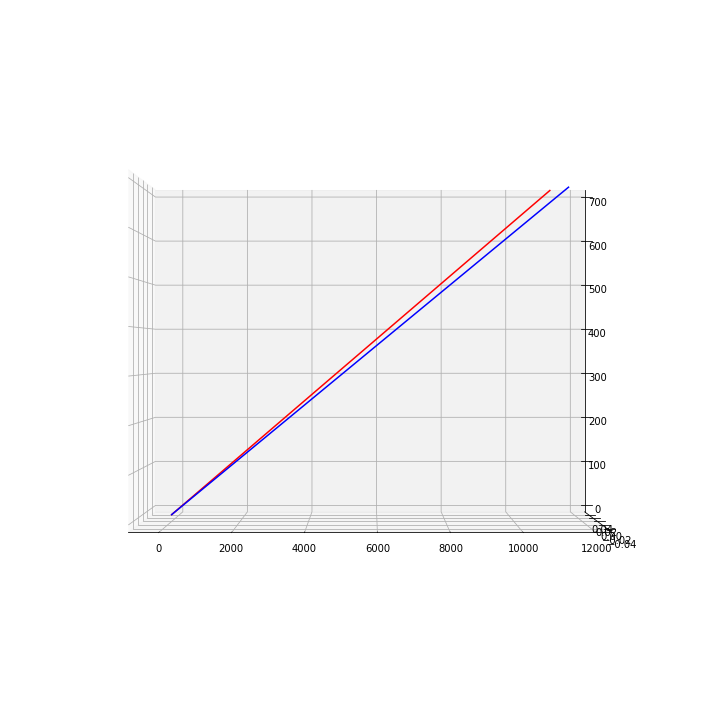

In [214]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]
# X0=x0
# Y0=[0 for i in range(node_N)]
# Z0=z0
# X=[fin[i] for i in range(0,node_N)]
# Y=[fin[i] for i in range(2*node_N,3*node_N)]
# Z=[fin[i] for i in range(4*node_N,5*node_N)]
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.view_init(-30,-30)
ax.view_init(0,-90)
    # ax.set_xlim([0, 5])
    # ax.set_ylim([0, 5])
plt.show()

In [215]:
X,Y,Z

(array([    0.        , 11599.22851227]),
 array([0., 0.]),
 array([  0.        , 701.50495076]))

In [216]:
X0,Y0,Z0

(array([    0.        , 11052.68484446]),
 array([0., 0.]),
 array([  0.        , 694.42189511]))

In [217]:
us=fin.T

In [218]:
t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

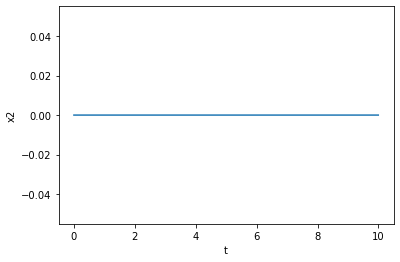

In [219]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

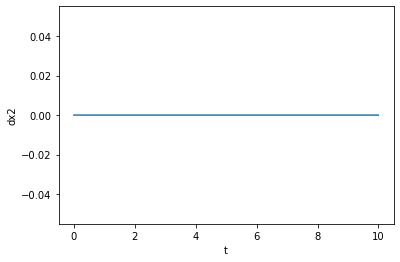

In [220]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

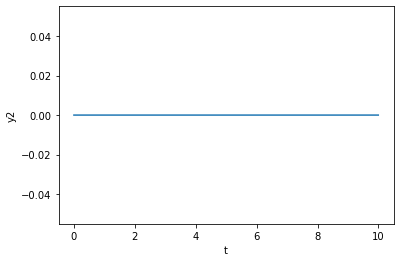

In [221]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

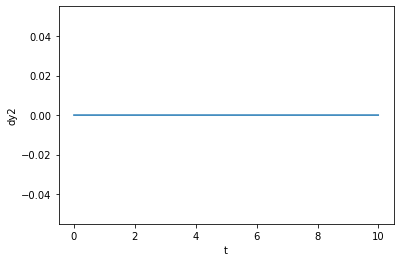

In [222]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

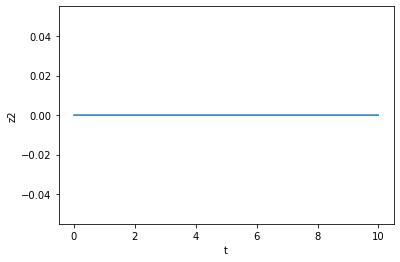

In [223]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

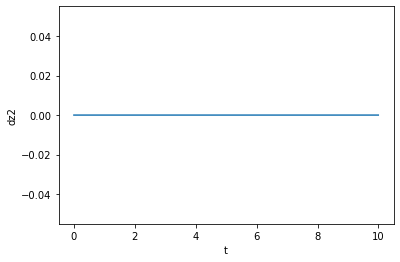

In [224]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [225]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

IndexError: index 34 is out of bounds for axis 1 with size 24

In [ ]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

In [ ]:
# E = 210e9

In [ ]:
# E*Ar

In [ ]:
# 1e10

In [ ]:
# import torch

In [ ]:
# A = torch.randn(20,3,3)
# B = torch.randn(20,3)
# X = torch.linalg.lstsq(A, B).solution # A is broadcasted to shape (2, 3, 3)


In [ ]:
# X

In [ ]:
# type(A)

In [ ]:
# X.shape

In [ ]:
# plot3D(fin, numDataPoints, FPS, filename, 3)